In [113]:
import pandas as pd
import numpy as np
from sklearn.cluster import OPTICS
from itertools import combinations
from DataProcessor import *
from RKDRetriever import *
from PairsSelection import *
from stdout import *
from pandas.tseries.offsets import BDay  

In [114]:
today = pd.Timestamp('2024-12-31')
total_months = 36
first_day = today - pd.DateOffset(months=total_months) + pd.DateOffset(days=1)

download_start = pd.Timestamp('2014-01-01')

bw = 120 # backward window size
hw = 10
time_delta = BDay(90) # Give some tolerance to the start date for the cold start
time_delta_2 = BDay(10) # No tolerance for the start date for the cold start

lag_days = 1
window_thr = 10
vol_thr = 0.7

#p_value threshold for the Engle-Granger test
pvalue_threshold = 0.20 # We select a relatively high p-value threshold to avoid discarding too many pairs
# And later we will select pairs with the lowest p-value, so it's ok to have a higher threshold here
N_top_pairs = 10 # Number of pairs to select

initial_capital = 10000
leverage = 1.0


In [115]:
DP = DataProcessor(download_start.strftime('%Y-%m-%dT%H:%M:%S'),(today+time_delta_2).strftime('%Y-%m-%dT%H:%M:%S'))
SPX = DP.get_index()

Stocks = DP.get_Stocks()

Authen success
Authen success


In [116]:
mask = Stocks.loc[first_day.strftime('%Y-%m-%d'):today].isna().any()
cols_with_na = mask[mask].index    

Stocks_clean = Stocks.drop(columns=cols_with_na)
Stocks_clean.loc[first_day.strftime('%Y-%m-%d'):today].isna().any().sum()

Stocks = Stocks_clean
Stocks

ACCP.PA                                                          \
               ASK     BID   CLOSE    HIGH     LOW   OPEN  VOLUME     VWAP   
TIMESTAMP                                                                    
2014-01-02  34.110  34.055  34.065  34.330  34.065  34.33  787449  34.1730   
2014-01-03  34.250  34.210  34.250  34.295  33.930  34.14  554382  34.2250   
2014-01-06  34.115  34.100  34.115  34.340  33.660  34.01  789902  34.1320   
2014-01-07  34.500  34.485  34.500  34.715  33.770  34.07  763548  34.3010   
2014-01-08  34.630  34.555  34.630  34.725  34.345  34.55  721577  34.6110   
...            ...     ...     ...     ...     ...    ...     ...      ...   
2025-01-08  46.700  46.640  46.690  46.980  46.060  46.58  407806  46.6205   
2025-01-09  47.240  47.140  47.220  47.300  46.400  46.40  407072  47.1165   
2025-01-10  47.240  47.230  47.230  47.600  47.090  47.25  493783  47.3215   
2025-01-13  46.840  46.820  46.820  47.160  46.550  47.01  500432  46.8354   
2025-01-14  47.520  47.400  47.510  47.640  47.100  47.20  606550  47.4696   

               AIRP.PA              ...        VIE.PA               VIV.PA  \
                   ASK         BID  ...        VOLUME       VWAP       ASK   
TIMESTAMP                           ...                                      
2014-01-02   61.113662   61.053183  ...  1.902591e+06  11.217165  1.660036   
2014-01-03   61.416055   61.385816  ...  1.526166e+06  11.252840  1.666248   
2014-01-06   60.176243   60.164147  ...  1.627652e+06  11.302977  1.649830   
2014-01-07   59.244872   59.208585  ...  1.917302e+06  11.400358  1.653823   
2014-01-08   59.740797   59.734749  ...  1.684131e+06  11.436996  1.643174   
...                ...         ...  ...           ...        ...       ...   
2025-01-08  157.700000  157.640000  ...  1.596590e+06  26.962800  2.413693   
2025-01-09  158.380000  158.260000  ...  9.927420e+05  26.952200  2.457024   
2025-01-10  156.100000  156.040000  ...  2.236035e+06  26.560600  2.440282   
2025-01-13  156.780000  156.480000  ...  1.355931e+06  26.381300  2.492476   
2025-01-14  155.900000  155.840000  ...  1.719676e+06  26.727200  2.475734   

                                                                       \
                 BID     CLOSE      HIGH       LOW      OPEN   VOLUME   
TIMESTAMP                                                               
2014-01-02  1.658705  1.659592  1.697310  1.655598  1.691098  3828186   
2014-01-03  1.665361  1.665361  1.678229  1.659148  1.663142  2476769   
2014-01-06  1.649386  1.649830  1.665361  1.644061  1.660923  2909418   
2014-01-07  1.653380  1.653823  1.658705  1.639180  1.650274  4655598   
2014-01-08  1.642286  1.642286  1.655155  1.636518  1.648055  4241098   
...              ...       ...       ...       ...       ...      ...   
2025-01-08  2.408769  2.413693  2.508232  2.407785  2.507247  7347835   
2025-01-09  2.456039  2.456039  2.456039  2.373317  2.399906  3444115   
2025-01-10  2.439298  2.439298  2.464902  2.422556  2.444221  4002008   
2025-01-13  2.491491  2.491491  2.505278  2.420587  2.426495  5761332   
2025-01-14  2.471795  2.471795  2.559441  2.471795  2.540730  6302625   

                      
                VWAP  
TIMESTAMP             
2014-01-02  1.668556  
2014-01-03  1.668112  
2014-01-06  1.651161  
2014-01-07  1.649386  
2014-01-08  1.642464  
...              ...  
2025-01-08  2.431222  
2025-01-09  2.438510  
2025-01-10  2.441956  
2025-01-13  2.483613  
2025-01-14  2.500452  

[2824 rows x 312 columns]

In [117]:
def flatten_Stocks(Stocks):
    """
    Flatten the stocks dataframe to a 2D array
    """
    df = Stocks.copy()
    df = df.reset_index()
    df.columns = ['date'] + [f"{ric}_{feature}" for ric, feature in df.columns[1:]]
    
    df_long = df.melt(id_vars=['date'], var_name='ticker_feature', value_name='value')
    df_long[['ticker', 'feature']] = df_long['ticker_feature'].str.rsplit('_', n=1,expand=True)
    df_long = df_long.drop(columns=['ticker_feature'])
    
    df_final = df_long.pivot_table(index=['date', 'ticker'], columns='feature', values='value').reset_index()

    return df_final

Stocks_flat = flatten_Stocks(Stocks)

Stocks_flat_raw = Stocks_flat
Stocks_flat = Stocks_flat.drop(columns=['ASK','BID'])
Stocks_flat.to_csv(smartFilename('Stocks_flat.csv'), index=False)
Stocks_flat

feature,date,ticker,CLOSE,HIGH,LOW,OPEN,VOLUME,VWAP
0,2014-01-02,ACCP.PA,34.065000,34.330000,34.065000,34.330000,7.874490e+05,34.173000
1,2014-01-02,AIRP.PA,61.053183,62.292995,61.053183,62.232517,8.750726e+05,61.397307
2,2014-01-02,AXAF.PA,19.715000,20.335000,19.715000,20.230000,4.909149e+06,19.876000
3,2014-01-02,BNPP.PA,55.540000,56.910000,55.350000,56.700000,3.165521e+06,55.907000
4,2014-01-02,BOUY.PA,27.075000,27.540000,27.045000,27.470000,7.224190e+05,27.181000
...,...,...,...,...,...,...,...,...
110117,2025-01-14,TEPRF.PA,83.680000,85.260000,83.180000,84.200000,2.744410e+05,84.110600
110118,2025-01-14,TTEF.PA,55.600000,55.940000,55.050000,55.110000,5.038034e+06,55.621300
110119,2025-01-14,URW.PA,71.160000,72.380000,70.960000,72.300000,2.756840e+05,71.321500
110120,2025-01-14,VIE.PA,26.650000,26.980000,26.600000,26.750000,1.719676e+06,26.727200


In [118]:
def _open_position(side, P1, P2, h, cap):

    denom = abs(h)*P1 + P2
    q = cap/denom
    if side == +1:   # buy h*S1, sell S2
        q1 =  +h*q
        q2 =  -q
    else:          # side==-1: buy S2, sell h*S1
        q1 =  -h*q
        q2 =  +q
    return q1, q2


def backtest_pair_3(pred_df, open_s1, open_s2, vwap_s1, vwap_s2, h, cap):

    pred_df = pred_df.sort_values('Date').reset_index(drop=True)

    pred_df['y_pred_shift_1'] = pred_df['y_pred'].shift(1).fillna(0).astype(int)
    pred_df['y_pred_shift_2'] = pred_df['y_pred'].shift(2).fillna(0).astype(int)
    
    log = []                                
    cash = cap
    margin = 0.0                             
    pos1 = pos2 = 0.0                       
    nav_mtm = []                            
    nav_real= []                            
    sp1,sp2 = 0.0, 0.0
    
    for i,row in pred_df.iterrows():
        sb = 0
        day  = row.Date
        sig  = row.y_pred_shift_1
        pre  = row.y_pred_shift_2
        
        if sig == np.nan:
            sig = 0
        if pre == np.nan:
            pre = 0

        
        open1,open2 = open_s1.loc[day], open_s2.loc[day]
        vwap1,vwap2 = vwap_s1.loc[day], vwap_s2.loc[day]
        

        # ---------------- Open/Close position  -----------------
        # Condition for closing position: previous position exists and signal != pre
        if pre!=0 and sig!=pre and pos1!=0:
        #if pre2!=0 and pre!=pre2 :

            # Calculate cash flow for closing position
            cash = (pos1) * vwap1 + (pos2) * vwap2 + margin     # Reserve cash
            margin = 0.0
            pnl  = (vwap1 - log[-1]['price_s1'])*pos1 + (vwap2 - log[-1]['price_s2'])*pos2
            log.append({'date':day,'action':'CLOSE','side':pre,
                        'qty1':-pos1,'qty2':-pos2,'price_s1':vwap1,'price_s2':vwap2,
                        'value':cash,'pnl':pnl})
            sp1 = log[-1]['price_s1']
            sp2 = log[-1]['price_s2']
            pos1 = pos2 = 0.0
            sb = 1

        # Codition for opening position: no previous position and signal != 0
        if pos1==0.0 and sig!=0:
        #if pos1==0.0 and pre!=0:

            q1,q2 = _open_position(sig,open1,open2,h,cap)
            
            log.append({'date':day,'action':'OPEN','side':sig,
                        'qty1':q1,'qty2':q2,'price_s1':open1,'price_s2':open2,
                        'value':cash,'pnl':np.nan})
            margin = cash - q1*open1 - q2*open2
            cash = 0  
            pos1, pos2 = q1, q2

        # ----------------  Daily NAV -----------------
        mtm = cash + pos1*vwap1 + pos2*vwap2 + margin
        nav_mtm.append((day,mtm))
        if sb:
            real = cash + pos1*sp1  + pos2*sp2 + margin
            nav_real.append((day,real))
        else:
            if log:
                real = cash + pos1*log[-1]['price_s1'] + pos2*log[-1]['price_s2'] + margin
                nav_real.append((day,real))
            else:
                nav_real.append((day,cash))

    nav_mtm  = pd.Series(dict(nav_mtm)).sort_index()
    nav_real = pd.Series(dict(nav_real)).sort_index()
    trade_log= pd.DataFrame(log)

    return nav_mtm, nav_real, trade_log

In [119]:
from typing import List, Dict, Tuple
import importlib
import FeatureEngineering
importlib.reload(FeatureEngineering)

# ---------------------------------------------------------------------------
VOL_DERIVS = {
    'CMF', 'FI', 'VPT', 'LogVol', 'Vol_R20', 'Illiquidity'
}

PRICE_DERIVS = lambda derivs: [d for d in derivs if d not in VOL_DERIVS]

PRICE_MAP = { f'{p}_spread': p for p in ['CLOSE', 'HIGH', 'LOW', 'OPEN', 'VWAP']}

def _build_tmp(df: pd.DataFrame, cols_map: dict, vol_col: str | None):
    tmp = df[list(cols_map.keys())].rename(columns=cols_map).copy()
    if vol_col:
        tmp['VOLUME'] = df[vol_col]
    else:        
        tmp['VOLUME'] = 1.0
    return tmp
# ---------------------------------------------------------------------------
# Core single‑pair helper
# ---------------------------------------------------------------------------

def compute_features_for_spread(spread_df: pd.DataFrame, derivatives: List[str]) -> pd.DataFrame:
    
    out = []
    price_only = PRICE_DERIVS(derivatives)
    if price_only:
        fe  = FeatureEngineering.FeatureEngineering()
        fe.setParams(
            _build_tmp(spread_df, PRICE_MAP, vol_col=None),
            price_only
        )
        fe.process()
        out.append(fe.data.add_suffix('_spread'))
        
    vol_only = [d for d in derivatives if d in VOL_DERIVS]
    if vol_only:
        for side in ('stock1', 'stock2'):
            cols_map = {f'{p}_{side}': p for p in ['CLOSE', 'HIGH', 'LOW', 'OPEN', 'VWAP']}
            fe = FeatureEngineering.FeatureEngineering()
            fe.setParams(
                _build_tmp(spread_df, cols_map, vol_col=f'VOLUME_{side}'),
                vol_only
            )
            fe.process()
            out.append(fe.data.add_suffix(f'_{side}'))
            
    return pd.concat(out, axis=1)

# ---------------------------------------------------------------------------
# ---------------------------------------------------------------------------

def batch_compute_spread_features(spreads_dict: Dict[Tuple[str, str], pd.DataFrame],
                                    derivatives: List[str]) -> Dict[Tuple[str, str], pd.DataFrame]:
    """Compute features for every pair DataFrame in *spreads_dict*."""
    return {pair: compute_features_for_spread(df, derivatives)
            for pair, df in spreads_dict.items()}

# ---------------------------------------------------------------------------
# ---------------------------------------------------------------------------

def compute_features_from_all_spreads(all_spreads: pd.DataFrame,
                                        derivatives: List[str]) -> pd.DataFrame:

    out_frames = []
    for pair_key in all_spreads.index.droplevel("Date").unique():
        pair_df = all_spreads.loc[pair_key]
        feats = compute_features_for_spread(pair_df, derivatives)
        feats = feats.assign(Stock1=pair_key[0], Stock2=pair_key[1]).set_index(['Stock1', 'Stock2'], append=True)
        feats = feats.reorder_levels(['Stock1', 'Stock2', feats.index.names[0]]).sort_index()

        out_frames.append(feats)

    return pd.concat(out_frames).sort_index()


In [120]:
def aggregate_feature_importance(importance_dfs):

    all_df = pd.concat(importance_dfs, axis=0)
    
    
    all_df['base_feature'] = all_df['feature'].apply(lambda x: '_'.join(x.split('_')[1:]) if '_' in x else x)
    
    
    grouped = all_df.groupby('base_feature')['importance'].mean().reset_index()
    grouped = grouped.sort_values(by='importance', ascending=False)

    return grouped

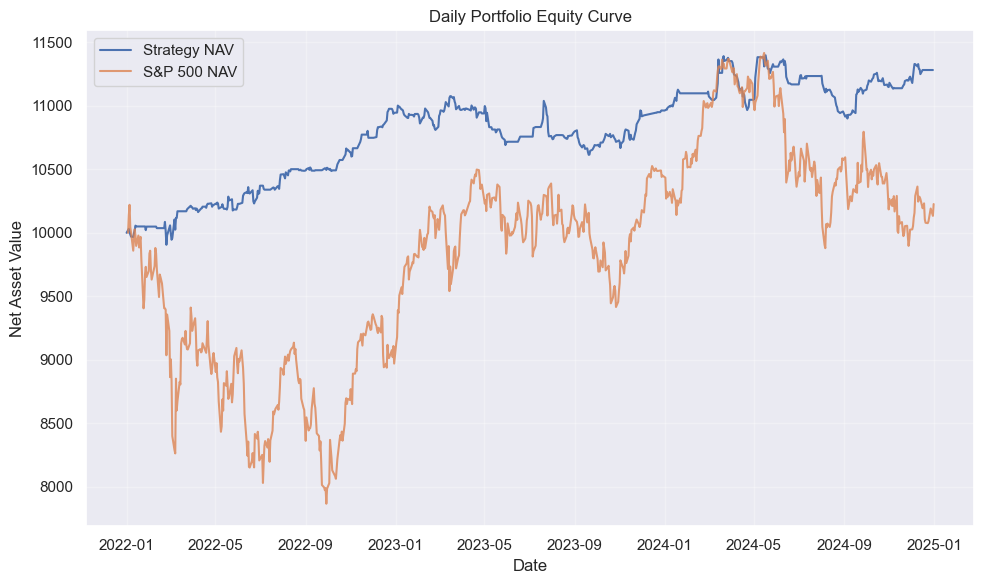


========== Portfolio Summary ==========
Annualized RR: 4.61%
Max DD: -4.37%
Sharpe Ratio: 1.01
=== S&P 500 Benchmark ===
Annualized Return: 0.74%
Max Drawdown:      -23.04%
Sharpe Ratio:      0.13

========== Overall Classification Report ==========
              precision    recall  f1-score   support

          -1      0.338     0.230     0.274       748
           0      0.531     0.658     0.588      1592
           1      0.344     0.277     0.307       746

    accuracy                          0.462      3086
   macro avg      0.404     0.389     0.389      3086
weighted avg      0.439     0.462     0.444      3086



In [121]:
from ta import add_all_ta_features
from sklearn.ensemble import RandomForestClassifier
#from sklearn.decomposition import PCA
#from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

Stocks_flat  = Stocks_flat.sort_values(["ticker", "date"])
Stocks_flat["Percent_Change"] = Stocks_flat.groupby("ticker")["CLOSE"].pct_change()
close_wide   = Stocks_flat.pivot(index="date", columns="ticker", values="CLOSE")
returns_wide = Stocks_flat.pivot(index="date", columns="ticker", values="Percent_Change")
open_wide    = Stocks_flat.pivot(index="date", columns="ticker", values="OPEN")
VWAP_wide    = Stocks_flat.pivot(index="date", columns="ticker", values="VWAP")

capital = initial_capital
window_nav   = []   
window_dates = []  

importance_all = []
all_y_test = []
all_y_pred = []
all_trades = []

trade_days = (
    Stocks_flat['date']          # All business days
    .drop_duplicates()
    .sort_values()
    .reset_index(drop=True)
)
trade_days = trade_days[trade_days <= today]  
day_idx = trade_days.searchsorted(first_day)

portfolio_nav = pd.Series(
    {first_day: initial_capital}, 
    dtype=float
)
# We use index of trade_days to find the first day

period_summaries = []
while day_idx < len(trade_days):
    
    day = trade_days.iloc[day_idx]
    training_end   = day - BDay(1)
    training_start = training_end - BDay(bw) + BDay(1)

    oos_start      = day
    oos_end        = oos_start + BDay(hw)  - BDay(1)
    if oos_end > trade_days.iloc[-1]:
        oos_end = trade_days.iloc[-1]
    
    SPX_train      = SPX.loc[training_start:training_end]
    SPX_test       = SPX.loc[oos_start:oos_end]

    SPX_train_close        = SPX_train['SPX']['close']
    SPX_train_returns      = SPX_train['SPX']['returns']
    SPX_test_close         = SPX_test['SPX']['close']

    Stocks_train_close      = close_wide.loc[training_start:training_end]
    Stocks_train_returns    = returns_wide.loc[training_start:training_end]
    # Because we use time_delta to keep some tolerance for the training start date
    # So the first day of return are not NAN
    Stocks_test_close       = close_wide.loc[oos_start:oos_end]
    
    coin_pairs = pairs_selection(Stocks_train_returns, SPX_train_returns, Stocks_train_close, min_sample=2, pvalue_threshold=pvalue_threshold)
    if coin_pairs.empty:
        day_idx = trade_days.searchsorted(oos_end, side="right")
        continue
    coin_pairs.sort_values(by='pvalue', ascending=True, inplace=True)
    #filename = smartFilename(f"coin_pairs_{training_start.strftime('%Y-%m-%d')}_{training_end.strftime('%Y-%m-%d')}_{oos_start.strftime('%Y-%m-%d')}_{oos_end.strftime('%Y-%m-%d')}.csv")
    #coin_pairs.to_csv(filename, index=False)
    coin_pairs = coin_pairs.head(N_top_pairs)
    N_pairs = len(coin_pairs)
    
    all_pair_features = []
    
    init_cap_each = capital 
    trades = []       
    pair_nav_list = [] 
    pair_names    = []
    hedge_ratios  = []
    
    for idx,row in coin_pairs.iterrows():
        stock1, stock2 = row['pair']
        h              = row['hedge_ratio']
        pair_names.append(f"{stock1}-{stock2}")
        hedge_ratios.append(h)
        df1 = Stocks_flat[Stocks_flat['ticker'] == stock1].set_index('date').sort_index().loc[(training_start-time_delta) : (oos_end+time_delta_2)].copy()
        df2 = Stocks_flat[Stocks_flat['ticker'] == stock2].set_index('date').sort_index().loc[(training_start-time_delta) : (oos_end+time_delta_2)].copy()
        
        df1_ta = add_all_ta_features(df1, open="OPEN", high="HIGH", low="LOW", close="CLOSE", volume="VOLUME", fillna=True)
        df2_ta = add_all_ta_features(df2, open="OPEN", high="HIGH", low="LOW", close="CLOSE", volume="VOLUME", fillna=True)
        
        df1_ta = df1_ta.add_prefix(f"{stock1}_")
        df2_ta = df2_ta.add_prefix(f"{stock2}_")
        
        df_pair = pd.concat([df1_ta, df2_ta], axis=1, join='inner')
        
        df_pair["pair"] = f"{stock1} - {stock2}"
        df_pair["date"] = df_pair.index
        #df_pair.to_csv(smartFilename(f"pair_features_{stock1}_{stock2}_{training_start.strftime('%Y-%m-%d')}_{training_end.strftime('%Y-%m-%d')}_{oos_start.strftime('%Y-%m-%d')}_{oos_end.strftime('%Y-%m-%d')}.csv"), index=False)

        df_pair["entry_price"]   =  h * df_pair[f"{stock1}_OPEN"].shift(-1) - df_pair[f"{stock2}_OPEN"].shift(-1)
        df_pair["exit_price"]    =  h * df_pair[f"{stock1}_VWAP"].shift(-lag_days-1) - df_pair[f"{stock2}_VWAP"].shift(-lag_days-1)
        df_pair["spread_return"] =  df_pair["exit_price"] - df_pair["entry_price"]
        # !!! Super important: we need to shift the entry price and exit price, so that 
        # We use all the info at day t to predict the relationship between open at day t+1 and VWAP at day t+lag_days+1
        # Here lag_days = 1
        
        vol  = df_pair["spread_return"].rolling(window=window_thr).std()
        mean = df_pair["spread_return"].rolling(window=window_thr).mean()
        
        #df_pair["vol_threshold"] = vol_thr * (vol1 + vol2) * (h * mean1 - mean2)
        df_pair["upper"] = vol_thr * vol + mean
        df_pair["lower"] = -vol_thr * vol + mean
        
        df_pair["label"] = 0
        df_pair.loc[df_pair["spread_return"] >  df_pair["upper"], "label"] = 1
        df_pair.loc[df_pair["spread_return"] < df_pair["lower"], "label"] = -1
        
        df_pair = df_pair.drop(columns=[f"{stock1}_ticker", f"{stock2}_ticker"])
        #df_pair.to_csv(smartFilename(f"pair_features_{stock1}_{stock2}_{training_start.strftime('%Y-%m-%d')}_{training_end.strftime('%Y-%m-%d')}_{oos_start.strftime('%Y-%m-%d')}_{oos_end.strftime('%Y-%m-%d')}_with_label.csv"), index=False)
    
        df_pair_train = df_pair[(df_pair["date"] >= training_start) & (df_pair["date"] <= training_end)]
        df_pair_test  = df_pair[(df_pair["date"] >= oos_start) & (df_pair["date"] <= oos_end)]
        
        if df_pair_test.empty:
            print(f"No OOS data between {oos_start} and {oos_end}, skip.")
            day_idx = trade_days.searchsorted(oos_end, side="right")
            continue
        
        drop_cols = ["label", "pair", "date", "entry_price", "exit_price", "spread_return", "upper", "lower",
                    f"{stock1}_OPEN", f"{stock1}_HIGH", f"{stock1}_CLOSE", f"{stock1}_LOW", f"{stock1}_VOLUME", f"{stock1}_VWAP",f"{stock1}_Percent_Change",
                    f"{stock2}_OPEN", f"{stock2}_HIGH", f"{stock2}_CLOSE", f"{stock2}_LOW", f"{stock2}_VOLUME", f"{stock2}_VWAP",f"{stock2}_Percent_Change",
                    f"{stock1}_volatility_bbhi",f"{stock1}_volatility_bbli",f"{stock1}_volatility_kchi",f"{stock1}_volatility_kcli",f"{stock1}_trend_psar_up",f"{stock1}_trend_psar_down",f"{stock1}_trend_psar_up_indicator",f"{stock1}_trend_psar_down_indicator",
                    f"{stock2}_volatility_bbhi",f"{stock2}_volatility_bbli",f"{stock2}_volatility_kchi",f"{stock2}_volatility_kcli",f"{stock2}_trend_psar_up",f"{stock2}_trend_psar_down",f"{stock2}_trend_psar_up_indicator",f"{stock2}_trend_psar_down_indicator",
                    f"{stock1}_volatility_kcl",f"{stock1}_volatility_dcl",f"{stock1}_volatility_dch",f"{stock1}_volatility_dcm",f"{stock1}_volatility_bbm",f"{stock1}_volatility_kch",f"{stock1}_volatility_kcc",
                    f"{stock2}_volatility_kcl",f"{stock2}_volatility_dcl",f"{stock2}_volatility_dch",f"{stock2}_volatility_dcm",f"{stock2}_volatility_bbm",f"{stock2}_volatility_kch",f"{stock2}_volatility_kcc",
                    f"{stock1}_trend_ichimoku_b",f"{stock1}_trend_ichimoku_base",f"{stock1}_trend_visual_ichimoku_b",f"{stock1}_trend_ichimoku_conv",f"{stock1}_trend_ichimoku_a",
                    f"{stock2}_trend_ichimoku_b",f"{stock2}_trend_ichimoku_base",f"{stock2}_trend_visual_ichimoku_b",f"{stock2}_trend_ichimoku_conv",f"{stock2}_trend_ichimoku_a",
                    f"{stock1}_trend_ema_fast",f"{stock1}_trend_ema_slow",f"{stock1}_trend_sma_fast",f"{stock1}_trend_aroon_ind",
                    f"{stock2}_trend_ema_fast",f"{stock2}_trend_ema_slow",f"{stock2}_trend_sma_fast",f"{stock2}_trend_aroon_ind",
                    f"{stock1}_trend_aroon_up",f"{stock1}_trend_visual_ichimoku_a",f"{stock1}_trend_aroon_down",f"{stock1}_momentum_ppo_signal",f"{stock1}_momentum_kama",
                    f"{stock2}_trend_aroon_up",f"{stock2}_trend_visual_ichimoku_a",f"{stock2}_trend_aroon_down",f"{stock2}_momentum_ppo_signal",f"{stock2}_momentum_kama",
                    f"{stock1}_others_dlr",f"{stock1}_momentum_ppo",f"{stock1}_momentum_pvo",f"{stock1}_momentum_pvo_signal",f"{stock1}_trend_macd_signal",f"{stock1}_trend_macd",f"{stock1}_trend_kst",f"{stock1}_trend_kst_sig",
                    f"{stock2}_others_dlr",f"{stock2}_momentum_ppo",f"{stock2}_momentum_pvo",f"{stock2}_momentum_pvo_signal",f"{stock2}_trend_macd_signal",f"{stock2}_trend_macd",f"{stock2}_trend_kst",f"{stock2}_trend_kst_sig",
                    f"{stock1}_trend_vortex_ind_neg",f"{stock1}_trend_vortex_ind_pos",f"{stock1}_trend_adx_pos",f"{stock1}_trend_adx_neg",f"{stock1}_momentum_stoch_rsi",
                    f"{stock2}_trend_vortex_ind_neg",f"{stock2}_trend_vortex_ind_pos",f"{stock2}_trend_adx_pos",f"{stock2}_trend_adx_neg",f"{stock2}_momentum_stoch_rsi",
                    
                    f"{stock1}_volatility_bbh",f"{stock1}_volatility_bbl",f"{stock1}_volatility_bbp",f"{stock1}_volatility_dcp",f"{stock1}_volatility_kcp",
                    f"{stock2}_volatility_bbh",f"{stock2}_volatility_bbl",f"{stock2}_volatility_bbp",f"{stock2}_volatility_dcp",f"{stock2}_volatility_kcp",
                    
                    f"{stock1}_volume_sma_em",f"{stock1}_volume_vwap",f"{stock1}_volume_nvi",f"{stock1}_trend_trix",
                    f"{stock2}_volume_sma_em",f"{stock2}_volume_vwap",f"{stock2}_volume_nvi",f"{stock2}_trend_trix",
                    ]
        feature_cols = [col for col in df_pair.columns if col not in drop_cols]
        
        
        X_train = df_pair_train[feature_cols]
        X_test  = df_pair_test[feature_cols]
        y_train = df_pair_train["label"]
        y_test  = df_pair_test["label"]
        
        X_train_scaled = X_train
        X_test_scaled  = X_test
        X_train_scaled_tmp = pd.DataFrame(X_train_scaled, columns=X_train.columns)
        X_test_scaled_tmp  = pd.DataFrame(X_test_scaled, columns=X_test.columns)
        
        weights = {-1: 1, 0: 1, 1: 1}
        rf = RandomForestClassifier(n_estimators=800, max_depth=15, random_state=42, class_weight=weights)
        rf.fit(X_train_scaled, y_train)
        
        y_pred = rf.predict(X_test_scaled)
        #print(f"Pair: {df_pair['pair'].iloc[0]}")
        #print(classification_report(y_test, y_pred, digits=3))
        importances = rf.feature_importances_
        feature_names = X_train_scaled_tmp.columns

        all_y_test.extend(y_test.tolist())
        all_y_pred.extend(y_pred.tolist())
        
        # 
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values(by='importance', ascending=False)

        #print(importance_df.head(30)) 
        importance_all.append(importance_df)
        
        pred_df = (
            df_pair_test[['date']]
            .rename(columns={'date':'Date'})
            .assign(y_pred=y_pred)
        )

        # open/high/low/vwap DataFrame 
        open_s1 = df_pair[f"{stock1}_OPEN"]
        open_s2 = df_pair[f"{stock2}_OPEN"]
        vwap_s1 = df_pair[f"{stock1}_VWAP"]
        vwap_s2 = df_pair[f"{stock2}_VWAP"]

        h  = row['hedge_ratio']
        
        nav_mtm, nav_real, trade_log = backtest_pair_3(pred_df, open_s1, open_s2, vwap_s1, vwap_s2, h, init_cap_each)
        pair_nav_list.append(nav_mtm.loc[oos_start:oos_end]) 

        trade_log = trade_log.assign(
                pair=f"{stock1}-{stock2}",
                window_start=oos_start,
                window_end=oos_end
                                )
        all_trades.append(trade_log)
    
    ends = [nav.iloc[-1] for nav in pair_nav_list]

    capital = float(np.mean(ends))
    
    period_summaries.append({
        'window_start': oos_start,
        'window_end':   oos_end,
        'n_pairs':      len(pair_nav_list),
        'pairs':        pair_names,
        'hedge_ratios': hedge_ratios,
        'capital_end':  capital
    })
        
    full_index = pd.date_range(oos_start, oos_end , freq='B')
    clean_navs = []
    for nav in pair_nav_list:
        nav = nav.reindex(full_index) 
        nav.iloc[0] = ends[0]                      
        nav.ffill(inplace=True)                           
        clean_navs.append(nav)
        
    window_df        = pd.concat(clean_navs, axis=1)
    port_nav_window  = window_df.sum(axis=1) / N_pairs          
    
    portfolio_nav    = pd.concat([portfolio_nav,port_nav_window.iloc[1:]]).sort_index()

    
    day_idx = trade_days.searchsorted(oos_end, side="right")

all_trades_df = pd.concat(all_trades, ignore_index=True)
all_trades_df['date'] = pd.to_datetime(all_trades_df['date'])
all_trades_df.to_csv("all_trades.csv", index=False)


period_df = pd.DataFrame(period_summaries)
period_df.to_csv("period_summaries.csv", index=False)

portfolio_nav = portfolio_nav.sort_index().ffill()

spx_close = SPX['SPX']['close'].loc[first_day:today]
spx_ret   = spx_close.pct_change().fillna(0)
spx_equity = (1 + spx_ret).cumprod() * initial_capital

plt.figure(figsize=(10,6))
plt.plot(portfolio_nav, label='Strategy NAV')
plt.plot(spx_equity,  label='S&P 500 NAV', alpha=0.8)
plt.title('Daily Portfolio Equity Curve')
plt.xlabel('Date')
plt.ylabel('Net Asset Value')
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

tot_ret = portfolio_nav.iloc[-1]/portfolio_nav.iloc[0]-1
trading_days = portfolio_nav.shape[0] - 1 
ann_ret = (1+tot_ret)**(252/trading_days)-1

n_days = spx_ret.shape[0]
spx_ann_ret = (spx_equity.iloc[-1] / spx_equity.iloc[0])**(252/n_days) - 1
spx_cummax  = spx_equity.cummax()
spx_mdd     = ((spx_equity - spx_cummax)/spx_cummax).min()
spx_sharpe  = np.sqrt(252) * spx_ret.mean() / spx_ret.std()

print("\n========== Portfolio Summary ==========")
print(f"Annualized RR: {ann_ret:.2%}")
print(f"Max DD: {(portfolio_nav/portfolio_nav.cummax()-1).min():.2%}")
print(f"Sharpe Ratio: {np.sqrt(252) * portfolio_nav.pct_change().mean() / portfolio_nav.pct_change().std():.2f}")

print("=== S&P 500 Benchmark ===")
print(f"Annualized Return: {spx_ann_ret:.2%}")
print(f"Max Drawdown:      {spx_mdd:.2%}")
print(f"Sharpe Ratio:      {spx_sharpe:.2f}")



print("\n========== Overall Classification Report ==========")
print(classification_report(all_y_test, all_y_pred, digits=3))


In [122]:
portfolio_nav

2022-01-01    10000.000000
2022-01-04    10031.367606
2022-01-05    10003.612710
2022-01-06     9987.158532
2022-01-07     9970.754028
                  ...     
2024-12-24    11282.715081
2024-12-25    11282.715081
2024-12-26    11282.715081
2024-12-27    11282.715081
2024-12-30    11282.715081
Length: 676, dtype: float64

In [123]:
report_dict = classification_report(all_y_test, all_y_pred, digits=3, output_dict=True)

# 转成 DataFrame，并把行索引（各个类别及指标名称）保留下来
df_report = pd.DataFrame(report_dict).T
df_report

,precision,recall,f1-score,support
-1,0.337917,0.229947,0.273667,748.000000
0,0.530633,0.658291,0.587609,1592.000000
1,0.343854,0.277480,0.307122,746.000000
accuracy,0.462411,0.462411,0.462411,0.462411
macro avg,0.404135,0.388573,0.389466,3086.000000
weighted avg,0.438770,0.462411,0.443710,3086.000000


              precision    recall  f1-score   support

          -1      0.338     0.230     0.274       748
           0      0.531     0.658     0.588      1592
           1      0.344     0.277     0.307       746

    accuracy                          0.462      3086
   macro avg      0.404     0.389     0.389      3086
weighted avg      0.439     0.462     0.444      3086



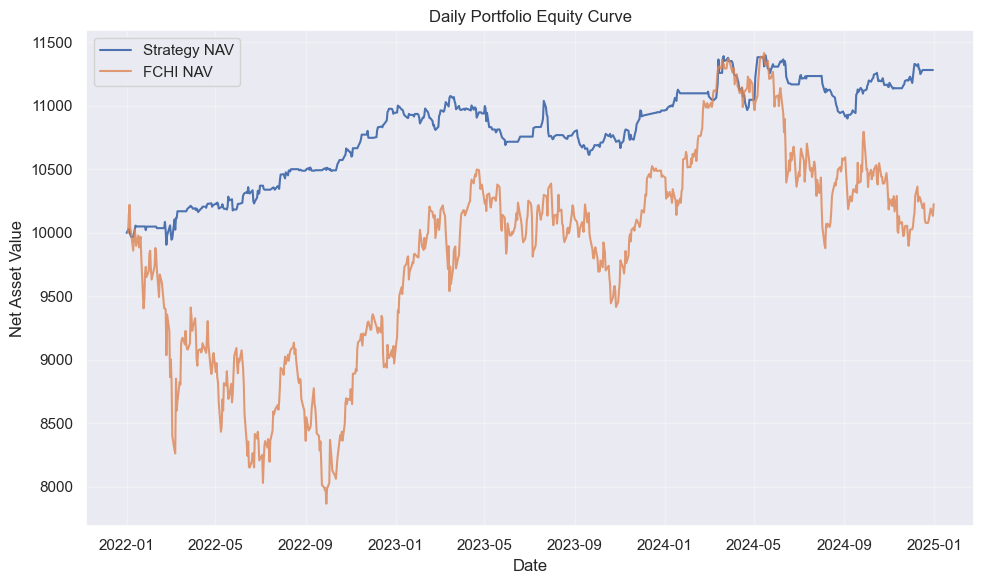


========== Portfolio Summary ==========
Annualized RR: 4.61%
Max DD: -4.37%
Sharpe Ratio: 1.01
=== S&P 500 Benchmark ===
Annualized Return: 0.74%
Max Drawdown:      -23.04%
Sharpe Ratio:      0.13


In [124]:
print(classification_report(all_y_test, all_y_pred, digits=3))
spx_close = SPX['SPX']['close'].loc[first_day:today]
spx_ret   = spx_close.pct_change().fillna(0)
spx_equity = (1 + spx_ret).cumprod() * initial_capital

plt.figure(figsize=(10,6))
plt.plot(portfolio_nav, label='Strategy NAV')
plt.plot(spx_equity,  label='FCHI NAV', alpha=0.8)
plt.title('Daily Portfolio Equity Curve')
plt.xlabel('Date')
plt.ylabel('Net Asset Value')
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


tot_ret = portfolio_nav.iloc[-1]/portfolio_nav.iloc[0]-1
trading_days = portfolio_nav.shape[0] - 1 
ann_ret = (1+tot_ret)**(252/trading_days)-1

n_days = spx_ret.shape[0]
spx_ann_ret = (spx_equity.iloc[-1] / spx_equity.iloc[0])**(252/n_days) - 1
spx_cummax  = spx_equity.cummax()
spx_mdd     = ((spx_equity - spx_cummax)/spx_cummax).min()
spx_sharpe  = np.sqrt(252) * spx_ret.mean() / spx_ret.std()

print("\n========== Portfolio Summary ==========")
print(f"Annualized RR: {ann_ret:.2%}")
print(f"Max DD: {(portfolio_nav/portfolio_nav.cummax()-1).min():.2%}")
print(f"Sharpe Ratio: {np.sqrt(252) * portfolio_nav.pct_change().mean() / portfolio_nav.pct_change().std():.2f}")
print("=== S&P 500 Benchmark ===")
print(f"Annualized Return: {spx_ann_ret:.2%}")
print(f"Max Drawdown:      {spx_mdd:.2%}")
print(f"Sharpe Ratio:      {spx_sharpe:.2f}")

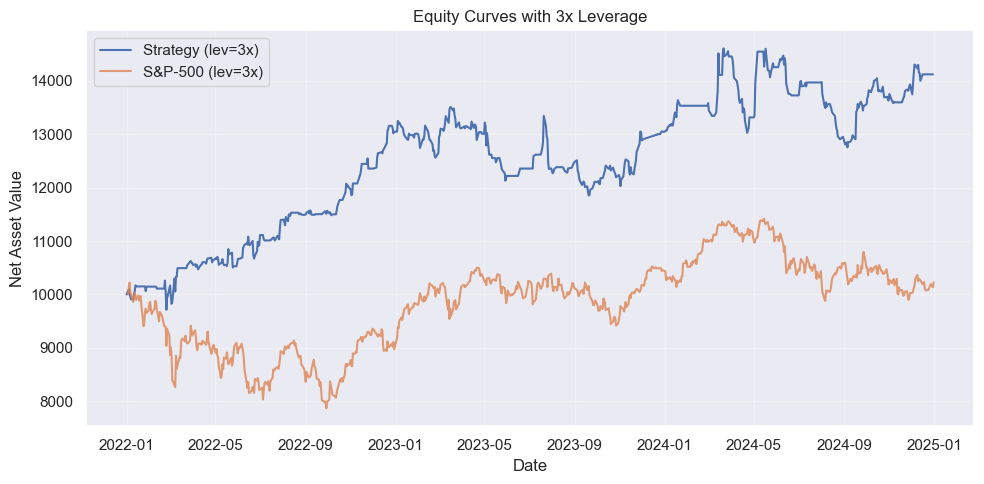

=== Leveraged Strategy ===
Annualized Return: 12.00%
Max Drawdown:      -12.70%
Sharpe Ratio:      1.01

=== Leveraged S&P500 ===
Annualized Return: 0.74%
Max Drawdown:      -23.04%
Sharpe Ratio:      0.13


In [125]:
leverage = 3
strat_ret = portfolio_nav.pct_change().fillna(0)
strat_ret_lev = strat_ret * leverage
strat_nav_lev = (1 + strat_ret_lev).cumprod() * initial_capital

spx_close = SPX['SPX']['close'].loc[first_day:today]
spx_ret   = spx_close.pct_change().fillna(0)
spx_equity = (1 + spx_ret).cumprod() * initial_capital


plt.figure(figsize=(10,5))
plt.plot(portfolio_nav.index, strat_nav_lev, label=f'Strategy (lev={leverage}x)')
plt.plot(spx_equity.index, spx_equity,  label=f'S&P-500 (lev={leverage}x)', alpha=0.8)
plt.title(f'Equity Curves with {leverage}x Leverage')
plt.xlabel('Date')
plt.ylabel('Net Asset Value')
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


n_days = spx_ret.shape[0]
ann_ret_strat = (strat_nav_lev.iloc[-1] / strat_nav_lev.iloc[0])**(252/n_days) - 1
mdd_strat     = (strat_nav_lev / strat_nav_lev.cummax() - 1).min()
sharpe_strat  = np.sqrt(252) * strat_ret_lev.mean() / strat_ret_lev.std()


spx_ann_ret = (spx_equity.iloc[-1] / spx_equity.iloc[0])**(252/n_days) - 1
spx_cummax  = spx_equity.cummax()
spx_mdd     = ((spx_equity - spx_cummax)/spx_cummax).min()
spx_sharpe  = np.sqrt(252) * spx_ret.mean() / spx_ret.std()

print("=== Leveraged Strategy ===")
print(f"Annualized Return: {ann_ret_strat:.2%}")
print(f"Max Drawdown:      {mdd_strat:.2%}")
print(f"Sharpe Ratio:      {sharpe_strat:.2f}")

print("\n=== Leveraged S&P500 ===")
print(f"Annualized Return: {spx_ann_ret:.2%}")
print(f"Max Drawdown:      {spx_mdd:.2%}")
print(f"Sharpe Ratio:      {spx_sharpe:.2f}")


In [126]:
portfolio_nav

2022-01-01    10000.000000
2022-01-04    10031.367606
2022-01-05    10003.612710
2022-01-06     9987.158532
2022-01-07     9970.754028
                  ...     
2024-12-24    11282.715081
2024-12-25    11282.715081
2024-12-26    11282.715081
2024-12-27    11282.715081
2024-12-30    11282.715081
Length: 676, dtype: float64

In [127]:
portfolio_nav.to_csv("portfolio_nav.csv", index=True)

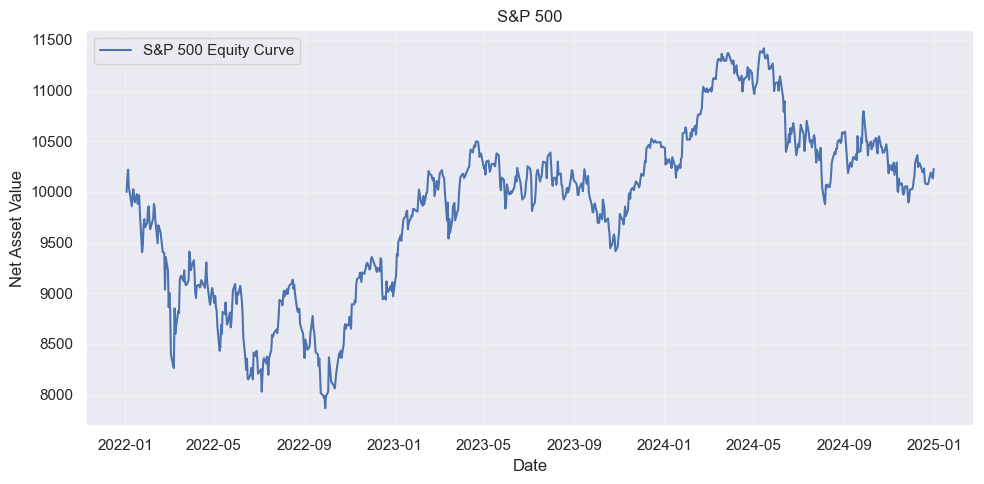

Annualized Return: 0.74%
Max Drawdown:      -23.04%
Sharpe Ratio:      0.13


In [128]:
initial_capital_tmp = 10000

spx_close_tmp = SPX['SPX']['close'].loc[first_day:today]
spx_ret_tmp   = spx_close_tmp.pct_change().fillna(0)

equity_tmp = (1 + spx_ret_tmp).cumprod() * initial_capital_tmp

n_days_tmp = spx_ret_tmp.shape[0]
annualized_return_tmp = (equity_tmp.iloc[-1] / equity_tmp.iloc[0]) ** (252 / n_days_tmp) - 1

cum_max_tmp = equity_tmp.cummax()
drawdown_tmp = (equity_tmp - cum_max_tmp) / cum_max_tmp
max_drawdown_tmp = drawdown_tmp.min()

sharpe_ratio_tmp = np.sqrt(252) * spx_ret_tmp.mean() / spx_ret_tmp.std()

plt.figure(figsize=(10,5))
plt.plot(equity_tmp, label='S&P 500 Equity Curve')
plt.title('S&P 500')
plt.xlabel('Date')
plt.ylabel('Net Asset Value')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Annualized Return: {annualized_return_tmp:.2%}")
print(f"Max Drawdown:      {max_drawdown_tmp:.2%}")
print(f"Sharpe Ratio:      {sharpe_ratio_tmp:.2f}")
